# WAVE FUNCTION GENERATION AS NOISE EVALUATION

In [67]:
# imports

from qiskit import *
from qiskit.circuit import *
from qiskit.extensions import RYGate
import math
import numpy as np
import matplotlib.pyplot as plt
import itertools

qiskit.__qiskit_version__

{'qiskit-terra': '0.14.2',
 'qiskit-aer': '0.5.2',
 'qiskit-ignis': '0.3.3',
 'qiskit-ibmq-provider': '0.7.2',
 'qiskit-aqua': '0.7.3',
 'qiskit': '0.19.6'}

 Ancillary functions, used to compute the angle.

 "$f(\sigma,\mu)$" is the discrete version of a Gaussian:
  $f(\sigma,\mu) = \sum\limits_{n=-M}^{M} e^{-\frac{(n-\mu)^2}{\sigma}}$ 
 Where M is an arbitrary large number (in our case, 1,000).

 The rotation angle $\alpha$ is defined as follows:
 $\alpha = \cos^{-1}\left(\sqrt{\frac{f(\sigma/2,\mu/2)}{f(\sigma,\mu)}}\right)$


In [68]:
def g_(sigma_, mu_, lim):
    # normalization function, equal to psi tilde squared, summed over all the integers.
    # in lieu of an infinite sum, we can simply make ``lim" sufficiently high. 
    return np.sum(np.exp((-(np.arange(-lim, lim+1, 1) - mu_)**2)/float((2)*sigma_**2)))


def angle_(sigma_, mu_, lim=10**3):
    # Calculates the angle, based on the square root of probability. 
    # cutoff the infinite sum in g_(...) at 10**3 by default
    return np.arccos(np.sqrt(g_(sigma_/2., mu_/2, lim)/g_(sigma_, mu_, lim)))

def ctrl_states(n):
    states = []
    for i in range(0,2**n):
        s = bin(i).replace("0b", "")
        states.append("".join(["0" for j in range(0,n-len(s))])+s)
    return states
ctrl_states(4)

['0000',
 '0001',
 '0010',
 '0011',
 '0100',
 '0101',
 '0110',
 '0111',
 '1000',
 '1001',
 '1010',
 '1011',
 '1100',
 '1101',
 '1110',
 '1111']

In [69]:
'''
def qubit_strings2(n):
    # Given parameter n, generate strings 0-(n-1) in binary.
    qubit_strings = []
    for q in itertools.product(['0', '1'], repeat=n):
        qubit_strings.append(''.join(q))
    return qubit_strings
'''
def new_mu(qub, mu):
    # calculate modified \mu for n-bit string qubit
    # i.e., we have g(b, mu) = (mu - b)/2, b \in {0,1}, and g('',mu) = mu
    # e.g., h('101101', mu) = g('1',g('0',g('1',g(...)))) etc.
    new_mean = mu
    for bit in qub[::-1]:#reversed because we consider the qubits increasingly further back
        new_mean = (new_mean/2.) - ((1/2.)*int(bit))
    return new_mean

 To each qubit, we apply the following rotation matrix:

 $R_y(2\alpha) = \begin{bmatrix}\cos\alpha&-\sin\alpha \\ \sin\alpha & \cos\alpha \end{bmatrix}$

In [70]:
def create_circ(N, mu_, sig_,):
    qr = QuantumRegister(N, 'q')
    cr = ClassicalRegister(N,'c')
    qc = QuantumCircuit(qr,cr)# Generate a quantum circuit with a quantum register (list) of qubit objects
    alpha_0 = angle_(sig_, mu_) # We multiply by 2, because the ry gate rotates by alpha/2
    qc.ry(2*alpha_0,0) # apply a rotation angle of alpha_0 (multiply by 2 because gate halves parameter)
    for i in range(1,N): # Steps to be done at level q_i
        qstring = ctrl_states(i) # create list of 2^i strings of length i
        for k in qstring:
            alpha_ = angle_(sig_/(2**i), new_mu(k, mu_)) # Calculate angle using modified mean
            new_gate = RYGate(2*alpha_).control(num_ctrl_qubits = i, 
                                                label = None, 
                                                ctrl_state=k) # control state is 
            qc.append(new_gate, qr[:i+1]) # add ry gate to level
    
    qc.measure(range(N), range(N))
    return qc

These are the parameters used in the Meduim article. I believe they must  satisfy the inequality  $2^{n-1} - \mu >> \sigma >> 1$

In [71]:
from qiskit.visualization import plot_histogram

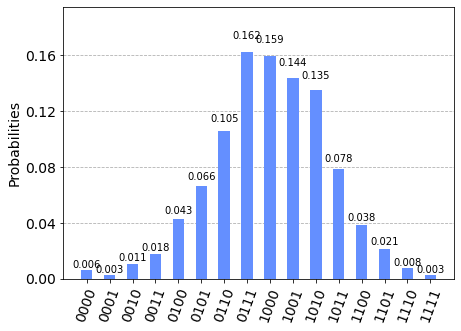

In [73]:
N = 4
sigma = 2**N/6.5
mu = 2**(N-1)

qc = create_circ(N,mu,sigma)

backend = Aer.get_backend('qasm_simulator')
result = execute(qc, backend).result()
# state = result.get_statevector()
qasm_counts = result.get_counts()
# print(state)
plot_histogram(qasm_counts)

# probs = [x*x for x in state]

# print('sum: ' + str(sum(probs)))

# # plot the probabilities
# wavefcn_xlist = list(ctrl_states(N))
# wavefcn_ylist = list(probs)
# plt.figure(figsize=(12, 10))
# plt.plot(range(len(wavefcn_ylist)), wavefcn_ylist)
# plt.xticks(range(len(wavefcn_xlist)), wavefcn_xlist, rotation=75)
# plt.xlabel('List of N-qubit States')
# plt.ylabel('Probabilities')
# plt.show()

## Test things on a real quantum computer

In [16]:
N = 4
sigma = 2**N/6.5
mu = 2**(N-1)
qc = create_circ(N,mu,sigma)

### Error analysis with cost functions

In [47]:
#Define expected output
def expected_output(i, N, sigma_, mu_, lim):
    return np.sum(np.exp((-(np.arange(-lim, lim+1, 1)*2**N-mu_+i)**2)/2/sigma_**2)/g_(sigma_,mu_,lim))

# def correct_output(N, sigma_, mu_):
#     return np.sum(si_(np.arange(0,2**N),N,sigma_,mu_,10**3))

quadratic deviation:5.238677319674668e-05


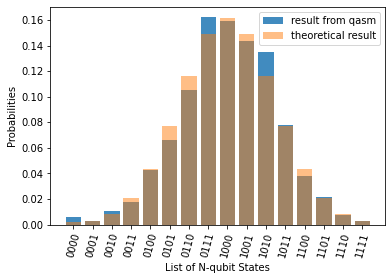

In [76]:
#The cost function

def quadratic_deviation(N, counts, sigma_, mu_, shots = 1024):
    quad_sum = 0
    keyset = ctrl_states(N)
    vis1 = []
    vis2 = []
    s=0
    for i in range(2**N):
#         print(expected_output(i,N, sigma_, mu_, 10**3))
#         print(counts[keyset[i]]/1024)
        vis1.append(expected_output(i,N, sigma_, mu_, 10**3))
        s+=expected_output(i,N, sigma_, mu_, 10**3)
        vis2.append(counts[keyset[i]]/shots)
        quad_sum+=(expected_output(i,N, sigma_, mu_, 10**3)-counts[keyset[i]]/shots)**2
        
    return quad_sum/2**N,vis1,vis2,s 

quad_dev,vis1,vis2,s = (quadratic_deviation(4,qasm_counts,sigma, mu))
print("quadratic deviation:"+str(quad_dev))
plt.bar(ctrl_states(N),vis2,label="result from qasm", alpha=0.85)
plt.bar(ctrl_states(N),vis1,label="theoretical result", alpha=0.5)
plt.xticks(range(len(vis1)), ctrl_states(N), rotation=75)
plt.xlabel('List of N-qubit States')
plt.ylabel('Probabilities')
plt.legend()

In [8]:
IBMQ.load_account() #log in

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [9]:
provider = IBMQ.get_provider(hub='ibm-q')
provider.backends() #list backends

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_vigo') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_ourense') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_london') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_burlington') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_essex') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>]

### Result on  <I>ibmq_burlington</I>

device loaded


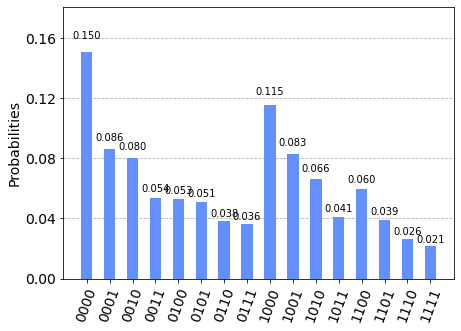

In [52]:
real_device = provider.get_backend('ibmq_burlington') #pick a device
print("device loaded")
job = execute(qc, real_device, shots=1024)
result = job.result() #execute circuit defined previously
burlington_counts = result.get_counts()
plot_histogram(burlington_counts) #display

quadratic deviation:0.004164038895918734


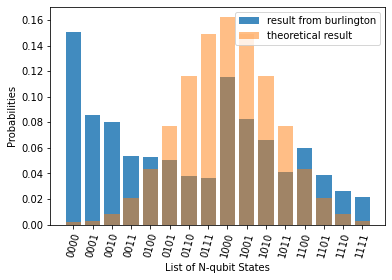

In [77]:
quad_dev,vis1,vis2,s = (quadratic_deviation(4,burlington_counts,sigma, mu))
print("quadratic deviation:"+str(quad_dev))
plt.bar(ctrl_states(N),vis2,label="result from burlington", alpha=0.85)
plt.bar(ctrl_states(N),vis1,label="theoretical result", alpha=0.5)
plt.xticks(range(len(vis1)), ctrl_states(N), rotation=75)
plt.xlabel('List of N-qubit States')
plt.ylabel('Probabilities')
plt.legend()

### Result on  <I>ibmq_london</I>

device loaded


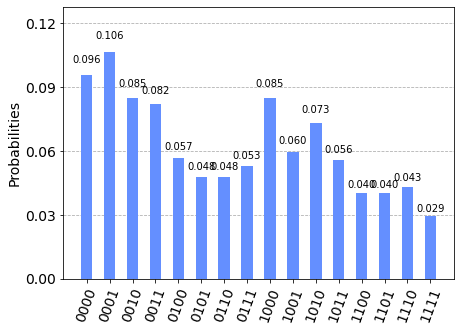

In [54]:
real_device = provider.get_backend('ibmq_london') #pick a device
print("device loaded")
result = execute(qc, real_device).result() #execute circuit defined previously
london_counts = result.get_counts()
plot_histogram(london_counts) #display

quadratic deviation:0.003927155571026828


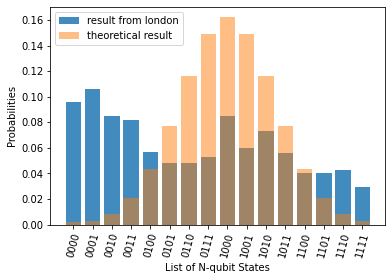

In [78]:
quad_dev,vis1,vis2,s = (quadratic_deviation(4,london_counts,sigma, mu))
print("quadratic deviation:"+str(quad_dev))
plt.bar(ctrl_states(N),vis2,label="result from london", alpha=0.85)
plt.bar(ctrl_states(N),vis1,label="theoretical result", alpha=0.5)
plt.xticks(range(len(vis1)), ctrl_states(N), rotation=75)
plt.xlabel('List of N-qubit States')
plt.ylabel('Probabilities')
plt.legend()

## Testing with simulated noise on emulator

In [15]:
from qiskit.providers.aer.noise import NoiseModel
import qiskit.providers.aer.noise as noise

### Sim with london noise model 

In [20]:
#extract map
real_device = provider.get_backend('ibmq_london') #pick a device
print("current device: "+str(real_device.name()))
properties = real_device.properties()
coupling_map = real_device.configuration().coupling_map
print(coupling_map)

current device: ibmq_london
[[0, 1], [1, 0], [1, 2], [1, 3], [2, 1], [3, 1], [3, 4], [4, 3]]


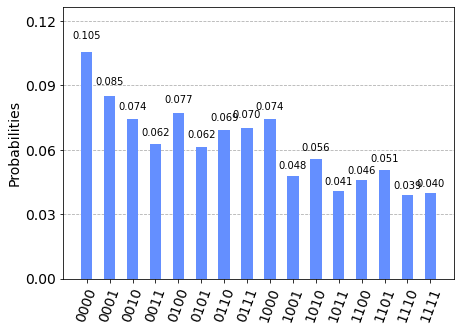

In [60]:
london_noise_model = NoiseModel.from_backend(properties)
emulator = Aer.get_backend('qasm_simulator')
job = execute(qc, emulator, shots=1024, noise_model=london_noise_model,
                    coupling_map=coupling_map,
                    basis_gates=london_noise_model.basis_gates)
counts=job.result().get_counts()
plot_histogram(counts) #display

### Sim with london noise model but no coupling map

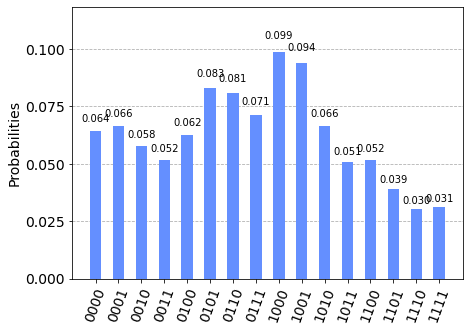

In [64]:
london_noise_model = NoiseModel.from_backend(properties)
emulator = Aer.get_backend('qasm_simulator')
job = execute(qc, emulator, shots=1024, noise_model=london_noise_model,
                    basis_gates=london_noise_model.basis_gates)
counts=job.result().get_counts()
plot_histogram(counts) #display

### Sim with burlington noise model 

In [61]:
#extract map
real_device = provider.get_backend('ibmq_burlington') #pick a device
print("current device: "+str(real_device.name()))
properties = real_device.properties()
coupling_map = real_device.configuration().coupling_map
print(coupling_map)

current device: ibmq_burlington
[[0, 1], [1, 0], [1, 2], [1, 3], [2, 1], [3, 1], [3, 4], [4, 3]]


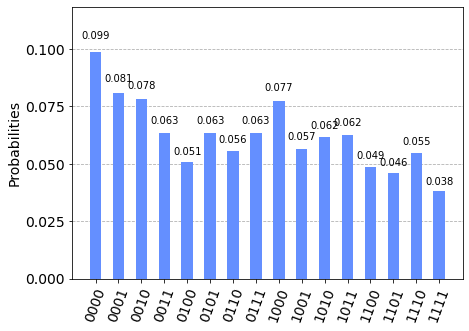

In [62]:
burlington_noise_model = NoiseModel.from_backend(properties)
emulator = Aer.get_backend('qasm_simulator')
job = execute(qc, emulator, shots=1024, noise_model=burlington_noise_model,
                    coupling_map=coupling_map,
                    basis_gates=burlington_noise_model.basis_gates)
counts=job.result().get_counts()
plot_histogram(counts) #display

In [ ]:
qc.draw(output='mpl')